<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/lstm_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads imports and installs

In [1]:
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py

--2019-06-04 12:03:42--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-06-04 12:03:48--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-06-04 12:03:48 (95.9 MB/s) - ‘lib.py’ saved [5214/5214]



In [2]:
import IPython.display as lab
import ipywidgets as ipy_widgets
import google.colab.widgets as colab_widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import functools
import keras
import lib

Using TensorFlow backend.


# Intro
this tutorial is made to learn keras datagenerators.

a small LSTM, procesing a input seqence of symbols and predicting a outputsymbol seqience is used snice data can be easyly generated.

format sings are used to gernated x samples, phython eval is used on the X to generate the Y values.

we a building a calculator.

### Encoding
a seqence of onehot encoded symbols s element alphabet, 
user defines input symbol seq len and output.

X.shape = (samples,  in_seqlen,  alphalen)   
Y.shape = (samples, out_seqlen,  alphalen)  

### Predicting a Sample
user will input a string, and want to read a string

for prediction encode -> predict -> decode is neccesary 
  
  
 

In [3]:
#@title Define context, sample dimensins { vertical-output: true }
alphabet        = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', ' '] #@param {type:""}

in_seq_len      = 5 #@param {type:"slider", min:2, max:20, step:1}
out_seq_len     = 4 #@param {type:"slider", min:1, max:10, step:1}
  
input_shape     = (in_seq_len,  len(alphabet))
output_shape    = (out_seq_len, len(alphabet))

print('input_shape:', input_shape, 'output_shape:', output_shape)

input_shape: (5, 14) output_shape: (4, 14)


In [0]:
int_to_char    = dict((i, c) for i, c in enumerate(alphabet))  
char_to_int    = dict((c, i) for i, c in enumerate(alphabet))

to_onehot      = lambda val: [1 if val==i else 0 for i in range(len(alphabet))] 

sample_encode  = lambda string:      [to_onehot(char_to_int[char]) for char in string]
sample_decode  = lambda hot: ''.join([int_to_char[np.argmax(step)] for step in hot])  

pad_r          = lambda s,l: s + ''.join([' ' for _ in range(l-len(s))])  
pad_l          = lambda s,l:     ''.join([' ' for _ in range(l-len(s))]) + s
pad            = pad_l

# Sample
data is generated as sting expresssin, by a formatstring, which is filled with random numbers [0,  max_int] 

a saple is created with its various encodings

In [0]:
default_sample_parameters = [['{:d}*{:d}', '{:d}+{:d}'], in_seq_len, 2, '{:d}', out_seq_len, [(0, 50)]]
    
class SampleParameters:
    def __init__(self, in_format, in_seq_len, var_count, out_format, out_seq_len, int_ranges):    
        self.in_seq_format = in_format
        self.in_seq_len = in_seq_len
        self.in_seq_vars = var_count
        self.out_seq_format = out_format
        self.out_seq_len = out_seq_len
        self.int_ranges = int_ranges
        
    def createSample(self, id):        
        def createVariableSet():
            #return [random.randint(0, max_int) for _ in range(n)]     
            arr2d = [[random.randint(*range_sec) for _ in range(int(self.in_seq_vars /len(self.int_ranges)))] for range_sec in self.int_ranges]
            arr   = [item for sublist in arr2d for item in sublist]    
            random.shuffle(np.array(arr))
            return arr
        random.seed(hash(id))
        rand_arr = createVariableSet()        
        x_exp_str = random.choice(self.in_seq_format).format(*rand_arr)
        y_val_str = self.out_seq_format.format(eval(x_exp_str))
        xstr = pad(x_exp_str, self.in_seq_len)
        ystr = pad(y_val_str, self.out_seq_len)
        assert(len(xstr) == input_shape[0])
        assert(len(ystr) == output_shape[0])
        return Sample(id, xstr, ystr, rand_arr, self)    

class Sample:  
    def __init__(self, id, x, y, v, parameter):    
        self.ID = id
        self.Xstr = x
        self.Ystr = y 
        self.Xvalues = v
        #self.Xoperators = o
        self.Xparameter = parameter
        
        self.Xhot = sample_encode(x)        
        self.Yhot = sample_encode(y)
        
        assert(len(np.array(self.Xhot).shape) == 2)    
        assert(len(np.array(self.Yhot).shape) == 2)    
        
        self.XhotShape = np.array(self.Xhot).shape
        self.YhotShape = np.array(self.Yhot).shape
        
    def __str__(self):
        return "{}:\t '{}' = '{}'".format(self.ID, self.Xstr, self.Ystr)
    
    def plot_error(self, sample_row_with_prediction):
        print(self, "\t", sample_row_with_prediction['Ypredicted'], "pedicted")
    
    def compilePandaColumns(self):        
        return { name : getattr(self, name) for name in ['ID', 'Xstr', 'XhotShape', 'Ystr', 'YhotShape', 'Xvalues']}  

# Sample Set

create some samples, and extracts the enhot encoded seqences X and y as a numpy arrays


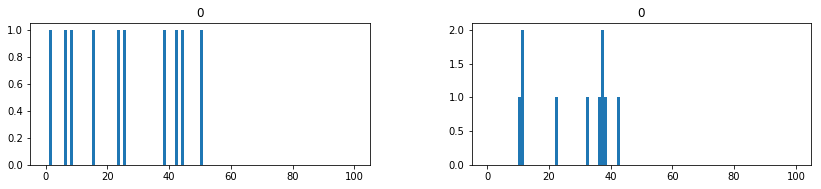

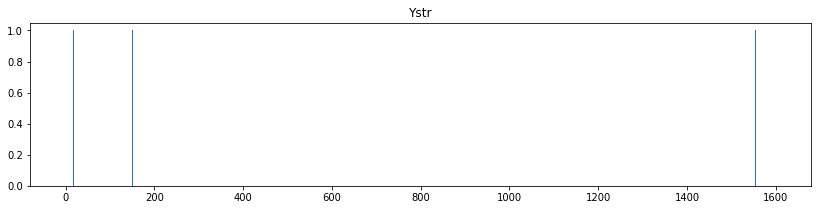

In [6]:
#@title Sample { vertical-output: true }
def generate_batch(set_path, sample_parameters, batch_size, batch_idx):
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):        
        ID = "%s/exp%d"%(set_path, (batch_size * batch_idx) + i)
        s = SampleParameters(*sample_parameters).createSample(ID)        
        X.append(s.Xhot)        
        y.append(s.Yhot)
        c.append({ 'BID':batch_idx, 'BPOS':i, **s.compilePandaColumns()})    
    
    assert(len(np.array(X).shape) == 3)    
    assert(len(np.array(y).shape) == 3)    
    index = pd.RangeIndex(batch_idx*batch_size, (batch_idx+1)*batch_size)
    return np.array(X), np.array(y), pd.DataFrame(index=index, data=c)
                         
def display_batch_stats(f):
    fig = plt.figure(figsize=(14, 6))    
    asnp = np.array(f['Xvalues'].to_list())    
    for n in range(asnp.shape[1]):
        frame = pd.DataFrame(asnp[:, n])
        args = { 
            'rwidth': 1,             
            'grid': False,
            'align': 'mid' #'left', 'mid', 'right'
        }
        frame.hist(**args, range=(0, 100), bins=100, ax=fig.add_subplot(220+n+1))    
        
    frame = pd.DataFrame(f['Ystr'].astype('int64'))
    frame.hist(**args, range=(0, 40*40), bins=40*40, figsize=(14, 3))
            
_, _, f = generate_batch('batch_demo', default_sample_parameters, 10, 0)
display_batch_stats(f)

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates kandinsky data for Keras'    
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=(), out_dim=(), sample_parameters=None):
        self.n_samples = samples
        self.batch_size = batch_size        
        self.set_path = set_path
        self.sample_parameters = sample_parameters
        
        self.in_dim = in_dim                
        self.out_dim = out_dim        
        
        print('DataGenerator: samples=', self.n_samples, "batchsize=", 
              self.batch_size, "len=", int(np.floor(self.n_samples / self.batch_size)))
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx):        
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X = np.empty((self.batch_size, *self.in_dim))
        y = np.empty((self.batch_size), dtype=int)
        X, y, _ = generate_batch(self.set_path, self.sample_parameters, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.sample_parameters, self.batch_size, idx)            
            panda = panda.append(f)
        print(len(self), "Batches touched")        
        self.panda = PandaSet(panda, self)
        return self 
    
class PandaSet:        
    def __init__(self, f, generator):
        "bound to the generator which created the data by BID and BPOS"
        self.f = f
        self.generator = generator
       
    def display_meta(self):                                                     ## abount the whole set
        "all abount the set properties"
        print(self.f.shape)
        t = colab_widgets.TabBar(["Info", "Plots"])    
        with t.output_to(0): self.f.info()                                      # panda info            
        with t.output_to(1): display_batch_stats(self.f)                        # stats            
        
    def display_content_slice(self, slicePanda, extra_view=None):               ## just a slice of it
        "show samples in detail"
        "by slice of panda"
        def display_XY():
            visible_samples = slicePanda.stop - slicePanda.start
            grid = colab_widgets.Grid(visible_samples, 2)            
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                BID = sample_row['BID']
                BPOS = sample_row['BPOS']
                batch = self.generator[BID]                
                with grid.output_to(i, 0): display(batch[0][BPOS])
                with grid.output_to(i, 1): display(batch[1][BPOS])
        
        t = colab_widgets.TabBar(["Panda", "Encoded X and Y", "Sample View", *(["Error Sample View"] if extra_view else [])])        
        with t.output_to("Panda"): display(self.f.iloc[slicePanda])             # panda slice  
        with t.output_to("Encoded X and Y"): display_XY()                       # X and Y encoded
            
            
        for row_idx, sample_row in self.f.iloc[slicePanda].iterrows():          # sample plots and sample based views
            ID = sample_row['ID']
            sample = SampleParameters(*default_sample_parameters).createSample(ID)            
            with t.output_to("Sample View"): print(sample)                
            if extra_view:
                with t.output_to("Error Sample View"): extra_view(sample, sample_row)        

# Create Training Data

In [8]:
#@title Sample Factory { vertical-output: true }
int_ranges      = [(0, 40)]          #@param {type:"raw"}
#int_ranges      = [(0, 20), (30, 50)]          #@param {type:"raw"}
in_seq_format   = ['{:d}*{:d}', '{:d}+{:d}']   #@param
in_seq_vars     = 2                            #@param
out_seq_format  = '{:d}'                       #@param {type:"string"}
out_seq_vars    = 'python eval of in_seq'      #@param {type:"raw"}

training_sample_parameters = [in_seq_format, in_seq_len, in_seq_vars, out_seq_format, out_seq_len, int_ranges]

s = SampleParameters(*training_sample_parameters).createSample("batch_demo/exp0")

print("generated string:", s)
print("encoded and back: batch_demo/exp0:\t '{}' = '{}'".format(sample_decode(s.Xhot), sample_decode(s.Yhot)))

generated string: batch_demo/exp0:	 '25*22' = ' 550'
encoded and back: batch_demo/exp0:	 '25*22' = ' 550'


training_sample_parameters= [['{:d}*{:d}', '{:d}+{:d}'], 5, 2, '{:d}', 4, [(0, 40)]]
DataGenerator: samples= 20000 batchsize= 100 len= 200
200 Batches touched
DataGenerator: samples= 1000 batchsize= 100 len= 10
10 Batches touched
(20000, 8)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
BID          20000 non-null int64
BPOS         20000 non-null int64
ID           20000 non-null object
XhotShape    20000 non-null object
Xstr         20000 non-null object
Xvalues      20000 non-null object
YhotShape    20000 non-null object
Ystr         20000 non-null object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

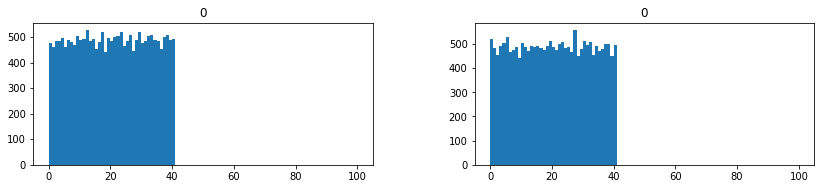

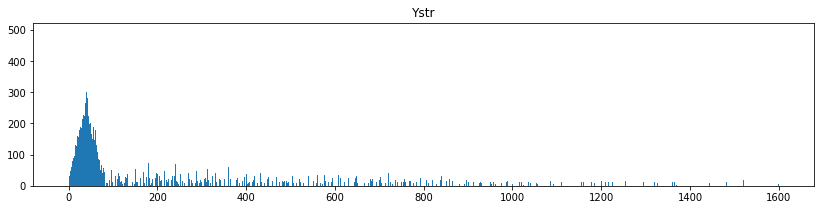

<IPython.core.display.Javascript object>

CPU times: user 6.45 s, sys: 396 ms, total: 6.84 s
Wall time: 6.38 s


In [9]:
#@title Train/Validate Generators { vertical-output: true, output-height: 200 }
%%time

batch_size      = 100 #@param {type:"slider", min:0, max:300, step:10}
training_size   = 20000 #@param {type:"slider", min:1000, max:50000, step:100}
validation_size = 1000 #@param {type:"slider", min:10, max:1000, step:10}

params = {
    'sample_parameters': training_sample_parameters,
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

print("training_sample_parameters=", training_sample_parameters)

training_generator = DataGenerator(
    samples=training_size, 
    set_path="train", 
    **params
).renderFrame()

validation_generator = DataGenerator(
    samples=validation_size, 
    set_path="validate", 
    **params
).renderFrame()

training_generator.panda.display_meta()

In [10]:
#@title Review Train Generator { run: "auto", vertical-output: true }

sample_to_view  = 9 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

training_generator.panda.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len),    
    #Xassert = 
    #Yassert = 
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,XhotShape,Xstr,Xvalues,YhotShape,Ystr
9,0,9,train/exp9,"(5, 14)",14+5,"[14, 5]","(4, 14)",19
10,0,10,train/exp10,"(5, 14)",8+0,"[8, 0]","(4, 14)",8
11,0,11,train/exp11,"(5, 14)",20*19,"[20, 19]","(4, 14)",380
12,0,12,train/exp12,"(5, 14)",23*23,"[23, 23]","(4, 14)",529
13,0,13,train/exp13,"(5, 14)",33*30,"[33, 30]","(4, 14)",990
14,0,14,train/exp14,"(5, 14)",6+40,"[6, 40]","(4, 14)",46
15,0,15,train/exp15,"(5, 14)",37*12,"[37, 12]","(4, 14)",444
16,0,16,train/exp16,"(5, 14)",6*37,"[6, 37]","(4, 14)",222
17,0,17,train/exp17,"(5, 14)",28+38,"[28, 38]","(4, 14)",66
18,0,18,train/exp18,"(5, 14)",22*5,"[22, 5]","(4, 14)",110


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp9:	 ' 14+5' = '  19'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp10:	 '  8+0' = '   8'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp11:	 '20+41' = '  61'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp12:	 '23*23' = ' 529'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp13:	 '33*30' = ' 990'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp14:	 ' 6+40' = '  46'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp15:	 '37*12' = ' 444'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp16:	 ' 6*37' = ' 222'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp17:	 '28+38' = '  66'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp18:	 ' 22*5' = ' 110'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp19:	 '31+37' = '  68'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp20:	 ' 4+14' = '  18'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp21:	 '17*31' = ' 527'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp22:	 '25*43' = '1075'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp23:	 '37+32' = '  69'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp24:	 '35*48' = '1680'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp25:	 ' 33+4' = '  37'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp26:	 '  4*2' = '   8'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp27:	 ' 5*15' = '  75'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train/exp28:	 ' 24+4' = '  28'


<IPython.core.display.Javascript object>

In [0]:
#training_generator = filter(training_generator)
#training_generator = filter(training_generator)
#training_generator = filter(training_generator)

# Data is ready - Time for the network

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 14)             714       
Total params: 76,914
Trainable params: 76,914
Non-trainable params: 0
_________________________________________________________________
None


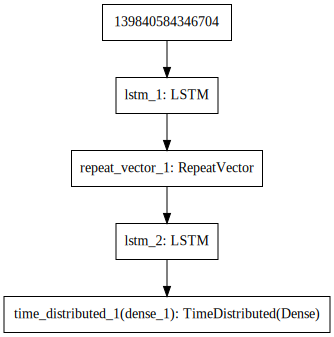

In [12]:
#@title Any LSTM configuration { vertical-output: true, output-height: 400 }
loss         = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
optimizer    = "adam"                     #@param ["adam" ,"other"]
main_metric  = "accuracy"                 #@param ["accuracy"]
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}
  
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, RepeatVector
  
model = Sequential()
model.add(LSTM(n1, input_shape=input_shape))
model.add(RepeatVector(out_seq_len))
model.add(LSTM(n2, return_sequences=True))
model.add(TimeDistributed(Dense(len(alphabet), activation='softmax')))
model.compile(loss=loss, optimizer=optimizer, metrics=[main_metric])

print(model.summary())
lab.SVG(keras.utils.vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

# Training

batch_size= 100 batch_count= 200 samples*= 20000 
epochs= 25 steps_per_epoch= 500 samples_per_step*= 40
Instructions for updating:
Use tf.cast instead.


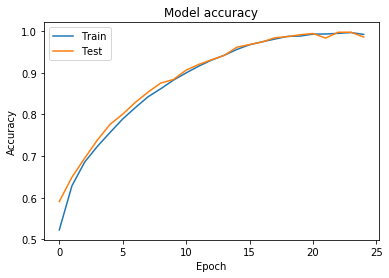

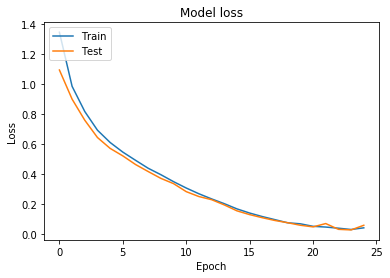

accuracy = 0.9922150044441224
accuracy = 0.9860000133514404
CPU times: user 5min 17s, sys: 35.5 s, total: 5min 52s
Wall time: 5min 52s


In [13]:
#@title Training { vertical-output: true }
%%time
steps_per_epoch    = 500 #@param {type:"slider", min:10, max:1000, step:1}
epochs             = 25 #@param {type:"slider", min:2, max:50, step:1}
use_multprocessing = True #@param {type:"boolean"}
workers            = 16 #@param {type:"slider", min:1, max:20, step:1}
verbose            = 0 #@param {type:"slider", min:0, max:5, step:1}

print(
    "batch_size=", training_generator.batch_size, 
    "batch_count=", len(training_generator), 
    "samples*=", training_generator.batch_size * len(training_generator), 
    "\nepochs=", epochs, 
    "steps_per_epoch=", steps_per_epoch, 
    "samples_per_step*=", int(training_generator.batch_size * len(training_generator) 
                              / steps_per_epoch)
)

history = model.fit_generator(  
  epochs = epochs,
  steps_per_epoch = steps_per_epoch,
  generator = training_generator,
  validation_data = validation_generator,                    
  use_multiprocessing = use_multprocessing,
  workers = workers,
  verbose = verbose,
)#callbacks = [keras.callbacks.EarlyStopping(monitor='val_acc', sensible=2)])

lib.plot_history(history)

print(main_metric, "=", history.history['acc'][-1])
print(main_metric, "=", history.history['val_acc'][-1])

# Test Set 1

In [0]:
#@title Test Sample Parameters { vertical-output: true }
int_ranges      = [(0, 40)]          #@param {type:"raw"}
in_seq_format   = ['{:d}*{:d}', '{:d}+{:d}']   #@param
in_seq_vars     = 2                            #@param
out_seq_format  = '{:d}'                       #@param {type:"raw"}
out_seq_vars    = 'python eval of in_seq'      #@param {type:"raw"}

test_sample_parameters = [in_seq_format, in_seq_len, in_seq_vars, out_seq_format, out_seq_len, int_ranges]

In [15]:
#@title Test Generator { vertical-output: true }
%%time
batch_size      = 200 #@param {type:"slider", min:1, max:300, step:10}
test_size       = 500000 #@param {type:"slider", min:10, max:500000, step:10}

params = {
    'sample_parameters': test_sample_parameters,
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

test_generator = DataGenerator(samples=test_size, set_path="test", **params).renderFrame()

DataGenerator: samples= 500000 batchsize= 200 len= 2500
2500 Batches touched
CPU times: user 2min 51s, sys: 1.24 s, total: 2min 53s
Wall time: 2min 53s


(500000, 8)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
BID          500000 non-null int64
BPOS         500000 non-null int64
ID           500000 non-null object
XhotShape    500000 non-null object
Xstr         500000 non-null object
Xvalues      500000 non-null object
YhotShape    500000 non-null object
Ystr         500000 non-null object
dtypes: int64(2), object(6)
memory usage: 30.5+ MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

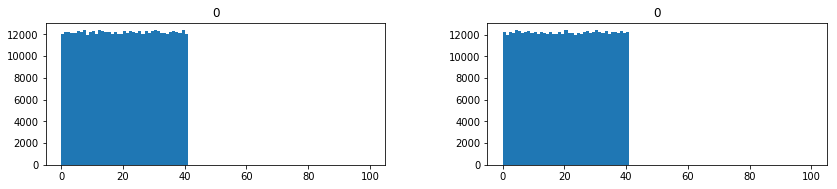

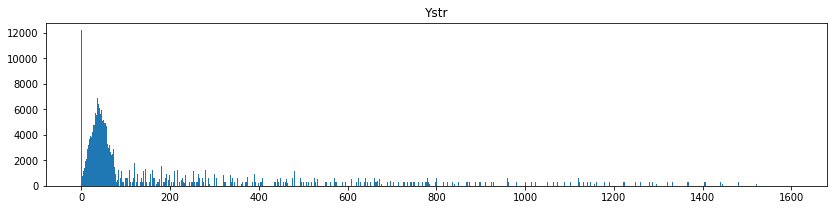

<IPython.core.display.Javascript object>

In [16]:
#@title Test Set Meta { vertical-output: true }
test_generator.panda.display_meta()

In [24]:
#@title View Test Set { run: "auto", vertical-output: true }
sample_to_view = 190428 #@param {type:"slider", min:0, max:500000, step:1}
view_len = 10 #@param {type:"slider", min:1, max:20, step:1}

test_generator.panda.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len),    
    #Xassert = 
    #Yassert = 
)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,XhotShape,Xstr,Xvalues,YhotShape,Ystr,Ypredicted,mask
190428,952,28,test/exp190428,"(5, 14)",17*40,"[17, 40]","(4, 14)",680,680,False
190429,952,29,test/exp190429,"(5, 14)",1+11,"[1, 11]","(4, 14)",12,12,False
190430,952,30,test/exp190430,"(5, 14)",20*38,"[20, 38]","(4, 14)",760,760,False
190431,952,31,test/exp190431,"(5, 14)",28*40,"[28, 40]","(4, 14)",1120,1120,False
190432,952,32,test/exp190432,"(5, 14)",6+25,"[6, 25]","(4, 14)",31,31,False
190433,952,33,test/exp190433,"(5, 14)",16*29,"[16, 29]","(4, 14)",464,464,False
190434,952,34,test/exp190434,"(5, 14)",32+36,"[32, 36]","(4, 14)",68,68,False
190435,952,35,test/exp190435,"(5, 14)",13*34,"[13, 34]","(4, 14)",442,442,False
190436,952,36,test/exp190436,"(5, 14)",32+34,"[32, 34]","(4, 14)",66,66,False
190437,952,37,test/exp190437,"(5, 14)",13+19,"[13, 19]","(4, 14)",32,32,False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190428:	 '17*40' = ' 680'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190429:	 ' 1+11' = '  12'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190430:	 '50*20' = '1000'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190431:	 '28*40' = '1120'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190432:	 ' 6+25' = '  31'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190433:	 '16*29' = ' 464'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190434:	 '48+32' = '  80'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190435:	 '13*34' = ' 442'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190436:	 '49+32' = '  81'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp190437:	 '13+19' = '  32'


<IPython.core.display.Javascript object>

# Evaluation 1

In [18]:
#@title Test Metrics { vertical-output: true }
"Accuracy %s" % model.evaluate_generator(test_generator, verbose=1)[1]

2500/2500 [==============================] - 73s 29ms/step


'Accuracy 0.9866179985046387'

In [19]:
#@title Predict and add Prediction to panda { vertical-output: true }

y_pred = model.predict_generator(test_generator, verbose=1)
y_pred_str = [ sample_decode(encoded) for encoded in y_pred ]

raw_panda = test_generator.panda.f
raw_panda['Ypredicted'] = y_pred_str

mask = (raw_panda['Ystr'] != raw_panda['Ypredicted'])

print("\nnumber of falsy predictions", np.sum(mask))
print("\nnumber of correct predictions", np.sum(~mask))

raw_panda['mask'] = mask


2500/2500 [==============================] - 72s 29ms/step

number of falsy predictions 23321

number of correct predictions 476679


(23321, 10)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23321 entries, 17 to 499972
Data columns (total 10 columns):
BID           23321 non-null int64
BPOS          23321 non-null int64
ID            23321 non-null object
XhotShape     23321 non-null object
Xstr          23321 non-null object
Xvalues       23321 non-null object
YhotShape     23321 non-null object
Ystr          23321 non-null object
Ypredicted    23321 non-null object
mask          23321 non-null bool
dtypes: bool(1), int64(2), object(7)
memory usage: 1.8+ MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

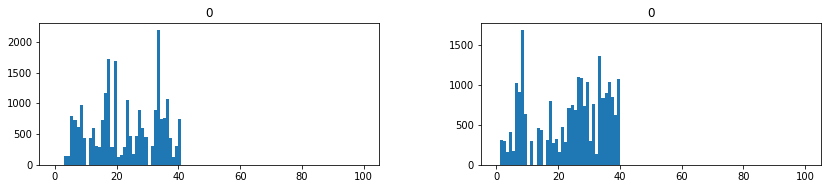

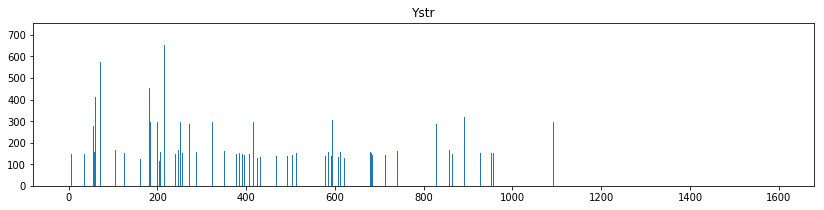

<IPython.core.display.Javascript object>

In [20]:
#@title Create Set of Errors { vertical-output: true }

error_set = PandaSet(raw_panda[mask], test_generator)

error_set.display_meta()

In [21]:
#@title View Error Samples { run: "auto", vertical-output: true } 
sample_to_view  = 36 #@param {type:"slider", min:0, max:10000, step:1}
view_len = 25 #@param {type:"slider", min:1, max:100, step:1}

error_set.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len), 
    extra_view = lambda s, r: s.plot_error(r)
    #Xassert = 
    #Yassert = 
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,XhotShape,Xstr,Xvalues,YhotShape,Ystr,Ypredicted,mask
1145,5,145,test/exp1145,"(5, 14)",5*27,"[5, 27]","(4, 14)",135,145,True
1181,5,181,test/exp1181,"(5, 14)",27*13,"[27, 13]","(4, 14)",351,391,True
1195,5,195,test/exp1195,"(5, 14)",17*16,"[17, 16]","(4, 14)",272,292,True
1227,6,27,test/exp1227,"(5, 14)",25*8,"[25, 8]","(4, 14)",200,100,True
1235,6,35,test/exp1235,"(5, 14)",26*7,"[26, 7]","(4, 14)",182,152,True
1328,6,128,test/exp1328,"(5, 14)",5*11,"[5, 11]","(4, 14)",55,25,True
1366,6,166,test/exp1366,"(5, 14)",33*29,"[33, 29]","(4, 14)",957,857,True
1425,7,25,test/exp1425,"(5, 14)",19*39,"[19, 39]","(4, 14)",741,041,True
1448,7,48,test/exp1448,"(5, 14)",26*36,"[26, 36]","(4, 14)",936,976,True
1470,7,70,test/exp1470,"(5, 14)",8*26,"[8, 26]","(4, 14)",208,128,True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1145:	 ' 5*27' = ' 135'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1145:	 ' 5*27' = ' 135' 	  145 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1181:	 '27*13' = ' 351'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1181:	 '27*13' = ' 351' 	  391 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1195:	 '17*16' = ' 272'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1195:	 '17*16' = ' 272' 	  292 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1227:	 ' 25*8' = ' 200'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1227:	 ' 25*8' = ' 200' 	  100 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1235:	 ' 26*7' = ' 182'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1235:	 ' 26*7' = ' 182' 	  152 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1328:	 ' 48*5' = ' 240'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1328:	 ' 48*5' = ' 240' 	   25 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1366:	 '33*29' = ' 957'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1366:	 '33*29' = ' 957' 	  857 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1425:	 '19*39' = ' 741'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1425:	 '19*39' = ' 741' 	  041 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1448:	 '26*36' = ' 936'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1448:	 '26*36' = ' 936' 	  976 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1470:	 ' 8*47' = ' 376'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1470:	 ' 8*47' = ' 376' 	  128 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1479:	 ' 25*8' = ' 200'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1479:	 ' 25*8' = ' 200' 	  100 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1510:	 '31*19' = ' 589'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1510:	 '31*19' = ' 589' 	  609 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1519:	 ' 32*8' = ' 256'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1519:	 ' 32*8' = ' 256' 	  156 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1568:	 '32*27' = ' 864'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1568:	 '32*27' = ' 864' 	  834 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1573:	 '28+45' = '  73'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1573:	 '28+45' = '  73' 	  332 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1616:	 ' 6*29' = ' 174'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1616:	 ' 6*29' = ' 174' 	  134 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1660:	 '26*36' = ' 936'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1660:	 '26*36' = ' 936' 	  976 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1681:	 '33*17' = ' 561'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1681:	 '33*17' = ' 561' 	  521 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1698:	 '17*35' = ' 595'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1698:	 '17*35' = ' 595' 	  695 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1724:	 ' 36*9' = ' 324'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1724:	 ' 36*9' = ' 324' 	  344 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1747:	 '43*15' = ' 645'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1747:	 '43*15' = ' 645' 	   40 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1784:	 '26*50' = '1300'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1784:	 '26*50' = '1300' 	  976 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1814:	 '28*39' = '1092'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1814:	 '28*39' = '1092' 	 1102 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1828:	 '24*21' = ' 504'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1828:	 '24*21' = ' 504' 	  484 pedicted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1898:	 '28*39' = '1092'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

test/exp1898:	 '28*39' = '1092' 	 1102 pedicted


<IPython.core.display.Javascript object>

In [22]:
#@title Use trained Model  { vertical-output: true }
def calculate(inp):
    print(inp, '=')
    padded = pad(inp, in_seq_len)  
    X = np.array([sample_encode(padded)])  
    result = model.predict(X)
    return sample_decode(result[0])

print(calculate('3*7'),   "should be", 3*7)
print(calculate('3+7'),   "should be", 3+7)
print(calculate('23*27'), "should be", 23*27)
print(calculate('23+27'), "should be", 23+27)
print(calculate('13*18'), "(maybe interpolated) should be", 13*18)
print(calculate('13+18'), "(maybe interpolated) should be", 13+18)

3*7 =
  21 should be 21
3+7 =
  10 should be 10
23*27 =
 621 should be 621
23+27 =
  50 should be 50
13*18 =
 234 (maybe interpolated) should be 234
13+18 =
  31 (maybe interpolated) should be 31


# Test Set 2

# Evaluation 2

In [23]:
#@title Use trained Model  { vertical-output: true }
print(calculate('3*43'),  "(extrapolated) should be", 3*43)
print(calculate('43*43'),  "(extrapolated) should be", 43*43)

3*43 =
 132 (extrapolated) should be 129
43*43 =
1360 (extrapolated) should be 1849
